In [1]:
import os
import gc
import time
import numpy as np; np.random.seed(42)
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# validation period to be used for test in all this notebook
valid_period = (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22"))

***
# Level 12

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 43 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_TX            int8          
 10  snap_WI            int8          
 11  snap_CA_cum        int8          
 12  snap_TX_cum        int8          
 13  snap_WI_cum        int8          
 14  event_name_1       int8          
 15  event_type_1       int8          
 16  event_name_2       int8          
 17  event_type_2       int8          
 18  sell_price         float32       
 19  n_prices           float32       
 20  regular_price      flo

In [4]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales_level12 = compute_scaling(scaling_input, agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)

In [5]:
# outlier removal
#remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
#data.drop(remove_idx, axis=0, inplace=True)

In [6]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':300,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**10-1,
    'min_data_in_leaf': 2**10-1,
    'learning_rate': 0.05, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "prev_newyear",
    "post_newyear",
    "no_stock_days",
]


model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    #"lags": list(range(1,15)),
    "window_shifts":[1,7,28,56],
    "window_functions":["mean","median","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{"item_id":"GLMMEncoder", 
                            "store_id":"default",
                            "state_id":"default",
                            "dept_id":"default",
                            "cat_id":"default",
                            "event_name_1":"default",
    },
    "ts_uid_columns":["item_id","store_id"],
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = [feat for feat in lagged_features if feat not in ["skew", "kurt"]]

***

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.838933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6153
[LightGBM] [Info] Number of data points in the train set: 24364230, number of used features: 71
Training until validation scores don't improve for 300 rounds
[25]	valid_0's wrmsseL12: 0.875242	valid_0's wrmsse: 1.11619
[50]	valid_0's wrmsseL12: 0.803201	valid_0's wrmsse: 0.664444
[75]	valid_0's wrmsseL12: 0.793149	valid_0's wrmsse: 0.55237
[100]	valid_0's wrmsseL12: 0.790699	valid_0's wrmsse: 0.520644
[125]	valid

NameError: name 'i' is not defined

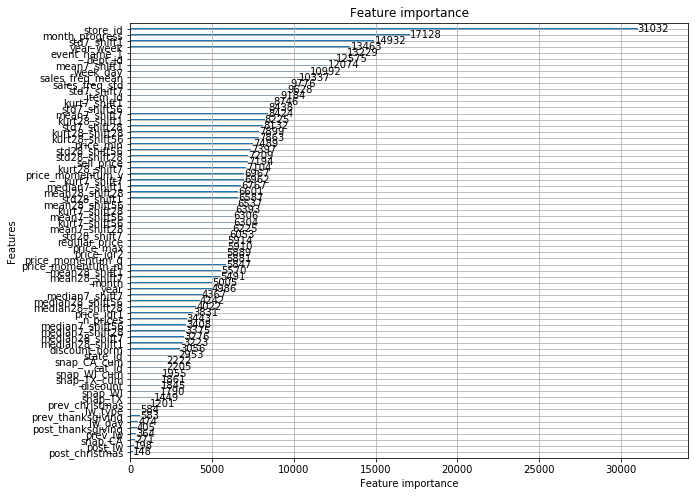

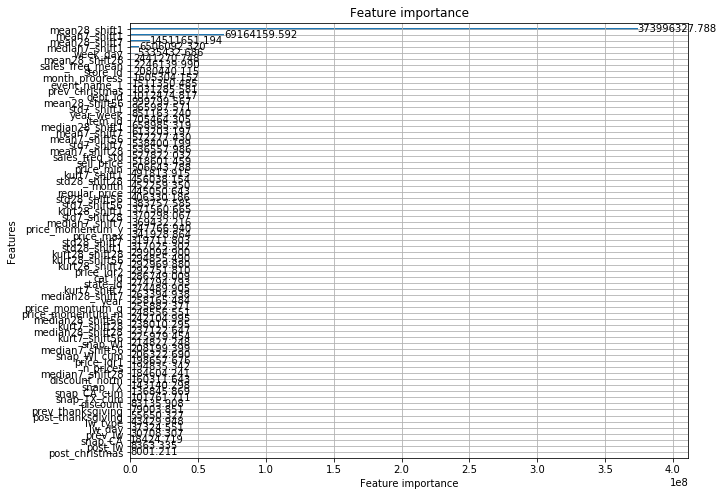

In [7]:
%%time

errors_v0 = dict()
errors_v1 = dict()

print("#"*100)
print(f" Validation period: {valid_period} ".center(100, "#"))
print("#"*100)

valid_start = valid_period[0]
valid_end = valid_period[1]
_train_data = data.query("ds <= @valid_end").reset_index(drop=True)
_valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

model_level12 = LightGBMForecaster(**model_kwargs)
model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index);
model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
model_level12.train_features = reduce_mem_usage(model_level12.train_features)
model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
ts_id_in_train = model_level12.train_features.ts_id.unique()
model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

# needed to remove leakage of 'no_stock' feature
#no_stock_ts = list()
#for threshold in [28, 56, 84, 112, 140, 168]:
#    left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
#    no_stock_ts.append((model_level12.train_features
#                        .query("ds >= @left_date")
#                        .groupby(["ts_id"])
#                        .filter(lambda x: np.all(x.y==0))
#                        .loc[:, ["ts_id"]]
#                        .drop_duplicates()))
#model_level12.valid_features["no_stock"] = 0
#for j,no_stock in enumerate(no_stock_ts):
#    idx = model_level12.valid_features.query("ts_id in @no_stock.ts_id").index
#    model_level12.valid_features.loc[idx, "no_stock"] = j+1

print("Fitting the model")
tic = time.time()
evaluator = Evaluator(model_level12.valid_features)
model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

valid_dataframe = (model_level12.valid_features
                   .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                   .copy())
evaluator = WRMSSEEvaluator(valid_dataframe)

print("Predicting with ground thruth lagged values")
tic = time.time()
forecast_f4_v0 = (model_level12.valid_features
                  .loc[:, ["ds"]+model_level12.ts_uid_columns]
                  .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
errors_v0[f"f{i}"] = evaluator.errors_by_level

print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True, bias_corr_func=bias_corr_func)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
errors_v1[f"f{i}"] = evaluator.errors_by_level

print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)

mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

gc.collect()

***
 hasta aqui se corrio la wea

In [11]:
print("Predicting with ground thruth lagged values")
tic = time.time()
forecast_f4_v0 = (model_level12.valid_features
                  .loc[:, ["ds"]+model_level12.ts_uid_columns]
                  .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

Predicting with ground thruth lagged values
Elapsed time: 0.3145024498303731 [min]


In [12]:
wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
evaluator.errors_by_level

{'root': 0.2854178833736188,
 ('state_id',): 0.35857852923897143,
 ('store_id',): 0.42345171544270566,
 ('cat_id',): 0.3181719624236491,
 ('dept_id',): 0.36925288529596756,
 ('state_id', 'cat_id'): 0.40891082900338593,
 ('state_id', 'dept_id'): 0.4585283776587674,
 ('store_id', 'cat_id'): 0.4823769844882267,
 ('store_id', 'dept_id'): 0.5446543310394373,
 ('item_id',): 0.7386738473375536,
 ('item_id', 'state_id'): 0.7708666276818747,
 ('item_id', 'store_id'): 0.7873076498332429}

In [17]:
print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

Predicting with recursive approach
Elapsed time: 19.43197917143504 [min]


In [18]:
wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)
evaluator.errors_by_level

{'root': 0.23058997759401995,
 ('state_id',): 0.31887457955779785,
 ('store_id',): 0.4267859266973645,
 ('cat_id',): 0.3218304809477237,
 ('dept_id',): 0.3951770536988227,
 ('state_id', 'cat_id'): 0.40160738819184827,
 ('state_id', 'dept_id'): 0.4769716419735044,
 ('store_id', 'cat_id'): 0.505055446760189,
 ('store_id', 'dept_id'): 0.5834761138491856,
 ('item_id',): 0.7883584779166934,
 ('item_id', 'state_id'): 0.8059019561158044,
 ('item_id', 'store_id'): 0.8145689001018821}

In [19]:
wrmsse

0.5057664952837364

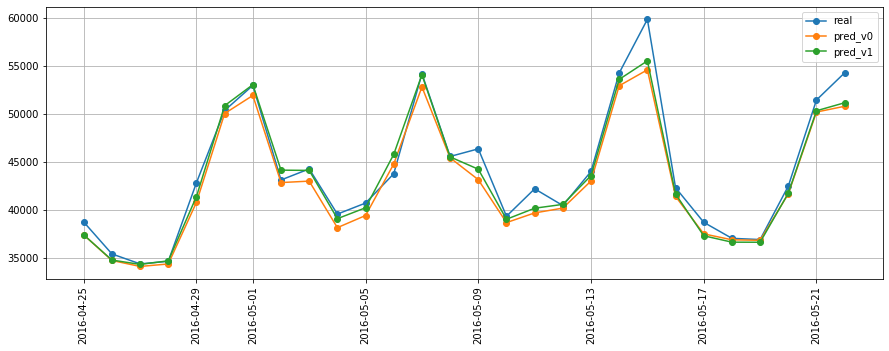

In [20]:
mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

In [10]:
wrmsse = evaluator._evaluate(forecast_f4_v0.y_pred.values)
errors_v0[f"f{i}"] = evaluator.errors_by_level

NameError: name 'errors_v0' is not defined

In [11]:
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)


wrmsse: 0.47759352925220333
{'root': 0.23525024264236422, ('state_id',): 0.3220856812995867, ('store_id',): 0.38892687141734, ('cat_id',): 0.2865881086922889, ('dept_id',): 0.3512361033156332, ('state_id', 'cat_id'): 0.3841531732093104, ('state_id', 'dept_id'): 0.4538348417847124, ('store_id', 'cat_id'): 0.46001000194423447, ('store_id', 'dept_id'): 0.5407177187295122, ('item_id',): 0.740693513328598, ('item_id', 'state_id'): 0.7753167858105126, ('item_id', 'store_id'): 0.7923093088523468}


In [12]:
print("Predicting with recursive approach")
tic = time.time()
valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
forecast_f4_v1 = model_level12.predict(valid_data, recursive=True)
tac = time.time()
print(f"Elapsed time: {(tac-tic)/60.} [min]")

Predicting with recursive approach
Elapsed time: 8.714069243272146 [min]


In [13]:
wrmsse = evaluator._evaluate(forecast_f4_v1.y_pred.values)

In [14]:
print("\nwrmsse:", wrmsse)
print(evaluator.errors_by_level)


wrmsse: 0.4821800490841232
{'root': 0.16738413795586202, ('state_id',): 0.2923803865731761, ('store_id',): 0.3940251204458656, ('cat_id',): 0.2666289383693724, ('dept_id',): 0.37500306646139325, ('state_id', 'cat_id'): 0.3703837795078212, ('state_id', 'dept_id'): 0.46673858284554565, ('store_id', 'cat_id'): 0.4667422098578195, ('store_id', 'dept_id'): 0.561806306521984, ('item_id',): 0.7936956099142718, ('item_id', 'state_id'): 0.8112095265754093, ('item_id', 'store_id'): 0.8201629239809574}


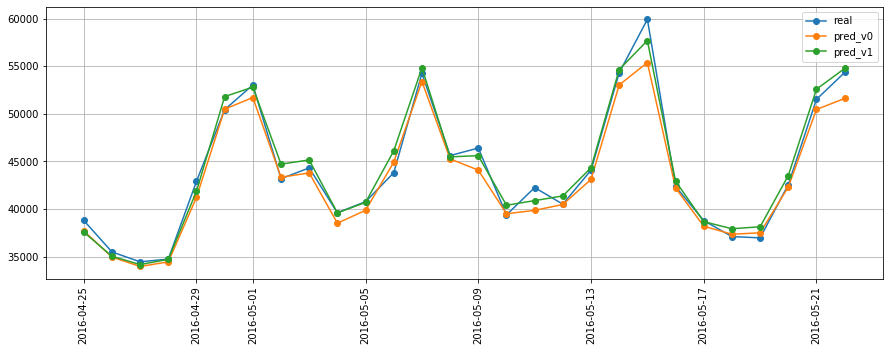

In [15]:
mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
       .merge(forecast_f4_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
       .merge(forecast_f4_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
plt.grid()
plt.xticks(rotation=90)
plt.legend(loc="best")
plt.show()

***